## clustering

In [49]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
torch.manual_seed(42);
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [39]:
n_clusters = 6
n_samples = 250

In [40]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [41]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [42]:
slices= [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [43]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    for i,centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid,markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid,markersize=5, marker="x", color='m', mew=2)

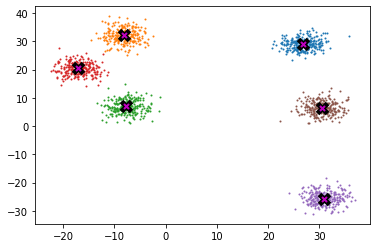

In [44]:
plot_data(centroids, data, n_samples)

## Meanshift

In [51]:
def gaussian(d,bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [52]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x,f(x))

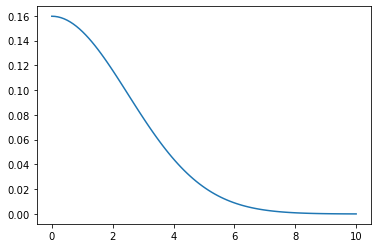

In [53]:
plot_func(partial(gaussian,bw=2.5))

In [54]:
def tri(d,i):
    return (-d+i).clamp_min(0)/i

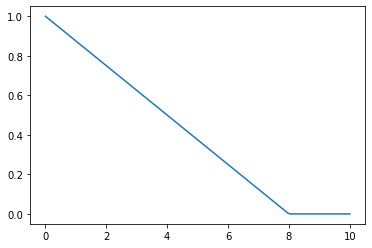

In [55]:
plot_func(partial(tri,i=8))

In [56]:
X = data.clone()
x = data[0]

In [57]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [58]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [59]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [60]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [61]:
delta = x-X
sum_sq = torch.einsum('ij,ij->i',delta,delta)
dist = sum_sq.sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [62]:
weight = gaussian(dist,2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [63]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [65]:
weight[:,None].shape

torch.Size([1500, 1])

In [66]:
weight[:,None]*X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [112]:
def one_update(X):
    for i, x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        #weight = gaussian(dist,2.5)
        weight = tri(dist,8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [113]:
def meanshift(data):
    X = data.clone()
    for i in range(5):
        one_update(X)
    return X

In [114]:
%time X=meanshift(data)

CPU times: user 665 ms, sys: 0 ns, total: 665 ms
Wall time: 662 ms


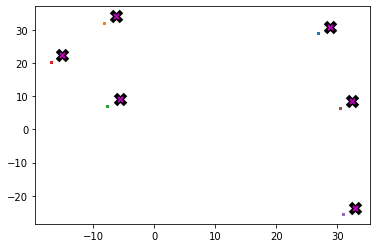

In [115]:
plot_data(centroids+2, X, n_samples)

In [116]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [117]:
def do_one(frame_number):
    if frame_number == 0:
        return plot_data(centroids+2,X,n_samples, ax=ax)
    one_update(X)
    ax.clear()
    plot_data(centroids+2,X,n_samples, ax=ax)

In [118]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig,do_one,frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

In [82]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [85]:
(x[:,None,:]-X).shape

torch.Size([5, 1500, 2])

In [88]:
def dist_b(a,b):
    return ((a[None]-b[:,None,:])**2).sum(2).sqrt()

In [89]:
dist_b(X,x).shape

torch.Size([5, 1500])

In [90]:
gaussian??

In [91]:
weight = gaussian(dist_b(X,x),2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [92]:
weight.shape, X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [93]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [94]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [95]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [100]:
torch.einsum('ij,jk->ik',weight,X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [103]:
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [106]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [107]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [120]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for i in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(i+bs,n))
            weight = gaussian(dist_b(X,X[s]),2.5)
            ##weight = tri(dist_b(X,X[s]),8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

In [121]:
data = data.cuda()

In [128]:
x = meanshift(data,1500).cpu()

In [132]:
%timeit -n 5 _ = meanshift(data,1500).cpu()

10.8 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


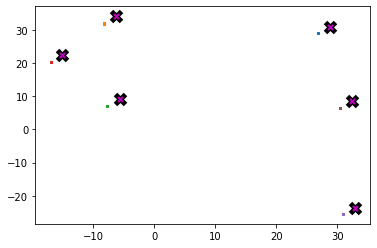

In [133]:
plot_data(centroids+2, X, n_samples)